In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def show(img, title="Image"):
    plt.figure(figsize=(6,6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


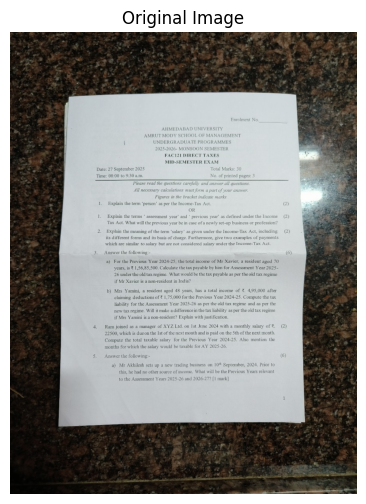

In [3]:
img = cv2.imread("/content/input.jpg")

if img is None:
    raise FileNotFoundError("ERROR: 'input.jpg' not found.")

orig = img.copy()
show(img, "Original Image")


In [4]:
def darken_background(image):
    img = image.copy()
    h, w = img.shape[:2]

    # 1. grayscale + blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7,7), 0)

    # 2. edges
    edges = cv2.Canny(blur, 50, 150)
    edges = cv2.dilate(edges, np.ones((5,5), np.uint8), 2)

    # 3. find contours
    cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    pts = None
    paper_mask = np.zeros((h, w), dtype=np.uint8)

    if cnts:
        cnt = max(cnts, key=cv2.contourArea)
        if cv2.contourArea(cnt) > 1000:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

            if len(approx) == 4:
                pts = approx.reshape(4,2).astype(int)
                cv2.fillPoly(paper_mask, [pts], 255)
            else:
                x,y,ww,hh = cv2.boundingRect(cnt)
                pts = np.array([[x,y],[x+ww,y],[x+ww,y+hh],[x,y+hh]], dtype=int)
                cv2.fillPoly(paper_mask, [pts], 255)

    # fallback: if no paper detected
    if np.count_nonzero(paper_mask) < 50:
        paper_mask = np.zeros((h,w), dtype=np.uint8)
        cv2.rectangle(paper_mask, (0,0), (w,h), 255, -1)
        pts = np.array([[0,0],[w,0],[w,h],[0,h]], dtype=int)

    # 4. recolor background
    out = img.copy()
    bg_mask = cv2.bitwise_not(paper_mask)
    dark_blue = (120, 40, 40)
    out[bg_mask == 255] = dark_blue

    return out, pts, paper_mask, edges


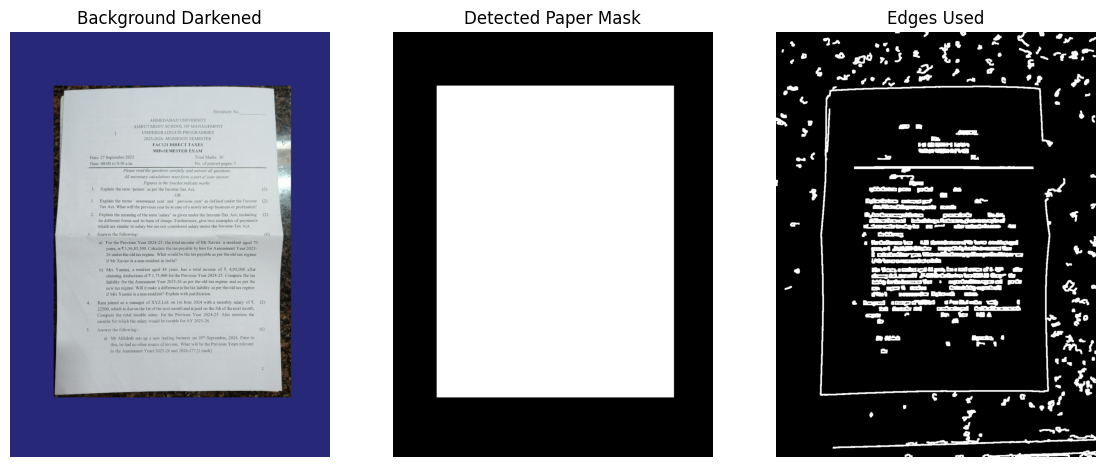

In [5]:
output, pts, paper_mask, edges = darken_background(img)

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Background Darkened")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(paper_mask, cmap='gray')
plt.title("Detected Paper Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(edges, cmap='gray')
plt.title("Edges Detected")
plt.axis("off")

plt.show()


In [6]:
def order_points(pts):
    rect = np.zeros((4,2), dtype="float32")
    s = pts.sum(axis=1)

    rect[0] = pts[np.argmin(s)]     # top-left
    rect[2] = pts[np.argmax(s)]     # bottom-right

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left

    return rect


In [7]:
def four_point_warp(image, pts):
    rect = order_points(pts.astype("float32"))
    (tl, tr, br, bl) = rect

    # width
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))

    # height
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))

    # destination grid
    dst = np.array([
        [0,0],
        [maxWidth-1, 0],
        [maxWidth-1, maxHeight-1],
        [0, maxHeight-1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped


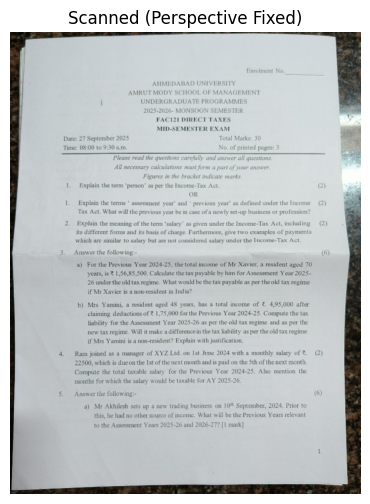

In [8]:
if pts is None:
    print("Cannot warp: No 4-point boundary found.")
else:
    scanned = four_point_warp(orig, pts)
    show(scanned, "Scanned (Perspective Corrected)")


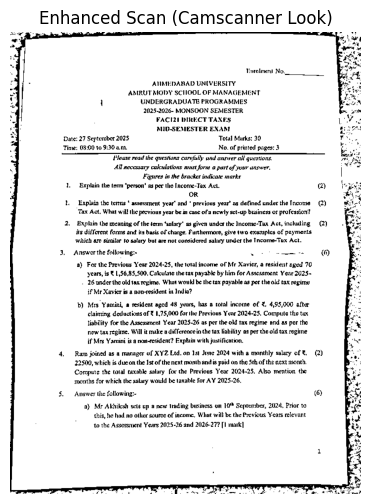

In [17]:
def enhance_scan(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    scan = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        25, 12
    )
    return scan

final_scan = enhance_scan(scanned)
show(final_scan, "Enhanced Image")


In [10]:
cv2.imwrite("final_scanned_output.jpg", final_scan)
print("Saved: final_scanned_output.jpg")


Saved: final_scanned_output.jpg
